# Speed dating machine learning


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns

In [332]:
df = pd.read_csv('speed_dating.csv')
df.head()

,has_null,wave,gender,age,age_o,d_age,d_d_age,race,race_o,samerace,...,expected_num_matches,d_expected_happy_with_sd_people,d_expected_num_interested_in_me,d_expected_num_matches,like,guess_prob_liked,d_like,d_guess_prob_liked,met,match
0,0,1.0,female,21.0,27.0,6.0,[4-6],Asian/Pacific Islander/Asian-American,European/Caucasian-American,0,...,4.0,[0-4],[0-3],[3-5],7.0,6.0,[6-8],[5-6],0.0,0
1,0,1.0,female,21.0,22.0,1.0,[0-1],Asian/Pacific Islander/Asian-American,European/Caucasian-American,0,...,4.0,[0-4],[0-3],[3-5],7.0,5.0,[6-8],[5-6],1.0,0
2,1,1.0,female,21.0,22.0,1.0,[0-1],Asian/Pacific Islander/Asian-American,Asian/Pacific Islander/Asian-American,1,...,4.0,[0-4],[0-3],[3-5],7.0,5.0,[6-8],[0-4],1.0,1
3,0,1.0,female,21.0,23.0,2.0,[2-3],Asian/Pacific Islander/Asian-American,European/Caucasian-American,0,...,4.0,[0-4],[0-3],[3-5],7.0,6.0,[6-8],[5-6],0.0,1
4,0,1.0,female,21.0,24.0,3.0,[2-3],Asian/Pacific Islander/Asian-American,Latino/Hispanic American,0,...,4.0,[0-4],[0-3],[3-5],6.0,6.0,[6-8],[5-6],0.0,1


## Feature Engineering
There are more than one hundred features in the dataset,in which 59 are categorical features. By exploring the features, we find there is only one feature, 'field', that has a high range of values, rest 'object'-features have 3-5 different values. Thus, we can use one-hot encoding to encode the features. Worth note: it may lead to sparse features. 

For the 'field' feature, by feature exploration, we also find that there are some values are only different because of the Capital letter, so we first transform the values of the 'field' feature to lowercase, then encode it with count encoding (frequency encoding) instead of one-hot encoding which leads to feature explosion. The 'field' feature in the end has 219 different values, 40 less compared to it before letter transformation.

Some features are highly correlated with other feature(s) such as those denote the differences between two other features, so I will drop these features of differences of other feature(s), for example 'd_d_age', 'd_importance_same_race', *etc*.

In [333]:
df['field'] = df['field'].str.lower()
X = df.copy()
y = pd.DataFrame(df.pop('match'), columns =['match'])
X = X.loc[:, ~X.columns.str.contains('d_')]
X.drop('match', axis=1, inplace=True)
# X.drop('has_null', axis=1, inplace=True)
X.head()

,has_null,wave,gender,age,age_o,race,race_o,samerace,importance_same_race,importance_same_religion,...,theater,movies,concerts,music,shopping,yoga,interests_correlate,like,guess_prob_liked,met
0,0,1.0,female,21.0,27.0,Asian/Pacific Islander/Asian-American,European/Caucasian-American,0,2.0,4.0,...,1.0,10.0,10.0,9.0,8.0,1.0,0.14,7.0,6.0,0.0
1,0,1.0,female,21.0,22.0,Asian/Pacific Islander/Asian-American,European/Caucasian-American,0,2.0,4.0,...,1.0,10.0,10.0,9.0,8.0,1.0,0.54,7.0,5.0,1.0
2,1,1.0,female,21.0,22.0,Asian/Pacific Islander/Asian-American,Asian/Pacific Islander/Asian-American,1,2.0,4.0,...,1.0,10.0,10.0,9.0,8.0,1.0,0.16,7.0,5.0,1.0
3,0,1.0,female,21.0,23.0,Asian/Pacific Islander/Asian-American,European/Caucasian-American,0,2.0,4.0,...,1.0,10.0,10.0,9.0,8.0,1.0,0.61,7.0,6.0,0.0
4,0,1.0,female,21.0,24.0,Asian/Pacific Islander/Asian-American,Latino/Hispanic American,0,2.0,4.0,...,1.0,10.0,10.0,9.0,8.0,1.0,0.21,6.0,6.0,0.0


In [334]:
Xtrain = X.copy()
ytrain = y.copy()

In [63]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=42)
# Xtrain, Xval, ytrain, yval = train_test_split(Xtrain, ytrain, test_size=0.1/0.8, random_state=42)

In [335]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from category_encoders.count import CountEncoder

ohe = OneHotEncoder()
std = StandardScaler()
cte = CountEncoder()

In [336]:
cat_col = Xtrain.select_dtypes(include='object').columns.drop('field')
num_col = Xtrain.drop(columns=cat_col).columns.drop('field')
field_col = Xtrain.drop(columns=num_col).columns.drop(cat_col)

In [337]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

cat_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

count_transformer = Pipeline(steps=[
    ('count', CountEncoder(handle_unknown='ignore'))
])

num_transformer = Pipeline(steps=[
    ('numeric', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_col),
        ('cat', cat_transformer, cat_col),
        ('count', count_transformer, field_col)
    ]
)

preprocessor.fit(Xtrain)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('numeric',
                                                  StandardScaler())]),
                                 Index(['has_null', 'wave', 'age', 'age_o', 'samerace', 'importance_same_race',
       'importance_same_religion', 'pref_o_attractive', 'pref_o_sincere',
       'pref_o_intelligence', 'pref_o_funny', 'pref_o_ambitious',
       'attractive_o', 'sinsere_o', 'intelligence_o', 'funny_o', 'ambitous_o',
       'att...
       'theater', 'movies', 'concerts', 'music', 'shopping', 'yoga',
       'interests_correlate', 'like', 'guess_prob_liked', 'met'],
      dtype='object')),
                                ('cat',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 Index(['gender', 'race', 'race_o'], dtype='object')),
                                ('count',
                                 Pipeline(steps=[('count',
                                                  CountEncoder(combine_min_nan_groups=True,
                                                               handle_unknown='ignore'))]),
                                 Index(['field'], dtype='object'))])

In [32]:
Xtrain_encoded = preprocessor.transform(Xtrain)
# Xval_encoded = preprocessor.transform(Xval)
# Xtest_encoded = preprocessor.transform(Xtest)

In [338]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans, DBSCAN, Birch, OPTICS, Birch
import numpy as np

def build_model(n_clusters=2, 
                init='random', n_init='auto', max_iter=300, tol=1e-4, random_state=None, algorithm_k='lloyd', verbose=0,    # parameters for kmeans model
                cluster_method='xi', min_cluster_size=None,   # parameters for optics model
                threshold=0.5, branching_factor=50,   # parameters for birch model
                algorithm='auto', eps=15, min_samples=5, metric='euclidean', metric_params = None, leaf_size=30, p=2, n_jobs=1    # parameters for dbscan model
                ):
    randomforest = Pipeline(steps=[
        ('preprocessor', preprocessor), 
        ('model', RandomForestClassifier)])

    kmeans = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', KMeans(n_clusters=n_clusters, 
                        n_init=n_init, 
                        max_iter=max_iter, 
                        tol=tol,
                        verbose=verbose,
                        random_state=random_state, 
                        algorithm=algorithm_k))])

    optics = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', OPTICS(min_samples=min_samples,
                        max_eps=np.inf, 
                        metric=metric, 
                        p=p, 
                        cluster_method=cluster_method, 
                        min_cluster_size=min_cluster_size, 
                        algorithm=algorithm, 
                        leaf_size=leaf_size))])

    birch = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', Birch(n_clusters=n_clusters, 
                        branching_factor=branching_factor))])

    dbscan = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', DBSCAN(eps=eps, 
                        min_samples=min_samples, 
                        metric=metric, 
                        metric_params=metric_params, 
                        leaf_size=leaf_size, 
                        p=p,
                        n_jobs=n_jobs))])
    return randomforest, kmeans, optics, birch, dbscan


In [339]:
from sklearn.manifold import TSNE, MDS, SpectralEmbedding
import umap

# umap_reducer = umap.UMAP(n_components=4)
# umap_embeding = umap_reducer.fit_transform(Xtrain_encoded)

tsne_reducer = TSNE(n_components=2, perplexity=50, method='barnes_hut')
tsne_embeding_train = tsne_reducer.fit_transform(Xtrain_encoded)
# tsne_embeding_test = tsne_reducer.fit_transform(Xtest_encoded)
# tsne_embeding_val = tsne_reducer.fit_transform(Xval_encoded)

In [17]:
my_palette = sns.color_palette(n_colors=25)

In [13]:
from sklearn.manifold import Isomap, smacof

The 'affinity' parameter of SpectralEmbedding must be a str among {'precomputed_nearest_neighbors', 'precomputed', 'nearest_neighbors', 'rbf'} or a callable. Got 'nearest_neightbors' instead.

In [ ]:
mds_reducer = MDS(n_components=2, random_state=42, dissimilarity='euclidean', n_jobs=-1)
spe_reducer = SpectralEmbedding(n_components=2, affinity='nearest_neighbors', random_state=42, eigen_solver='arpack',  n_neighbors=4, n_jobs=-1)
ism_reducer = Isomap(n_neighbors=400, n_components=2, eigen_solver='auto', path_method='auto', neighbors_algorithm='auto', metric='minkowski', p=2)

In [310]:
# mds_embedding = mds_reducer.fit_transform(Xtrain_encoded)
spe_embedding = spe_reducer.fit_transform(Xtrain_encoded)

/Users/lin.yang/miniconda3/envs/dsp/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


In [ ]:
ism_embedding = ism_reducer.fit_transform(Xtrain_encoded)

#### DBSCAN

'sokalmichener', 'rogerstanimoto', 'cosine', 'braycurtis', 'sokalsneath', 'dice', 'nan_euclidean', 'precomputed', 'l2', 'matching', 'canberra', 'l1', 'yule', 'cityblock', 'kulsinski', 'correlation', 'jaccard', 'sqeuclidean', 'euclidean', 'haversine', 'seuclidean', 'hamming', 'wminkowski', 'russellrao', 'manhattan', 'mahalanobis', 'minkowski', 'chebyshev'

当前最佳参数组合：eps=11, min_samples=181, metric='chebyshev': silhouette score: 0.7121166454500091

备选参数组合：eps=12, min_samples=152, metric='minkowski', algorithm='kd_tree', p=3: silhouette score: 0.7121166454500091

In [343]:
models = build_model(eps=6, min_samples=10, metric='minkowski', algorithm='kd_tree', leaf_size=30, p=3, n_jobs=-1)
dbscan_model = models[-1]
dbscan_model.fit(Xtrain)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('numeric',
                                                                   StandardScaler())]),
                                                  Index(['has_null', 'wave', 'age', 'age_o', 'samerace', 'importance_same_race',
       'importance_same_religion', 'pref_o_attractive', 'pref_o_sincere',
       'pref_o_intelligence', 'pref_o_funny', 'pref_o_ambitious',
       'attractive_o', 'sinsere_o', 'intelligenc...
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['gender', 'race', 'race_o'], dtype='object')),
                                                 ('count',
                                                  Pipeline(steps=[('count',
                                                                   CountEncoder(combine_min_nan_groups=True,
                                                                                handle_unknown='ignore'))]),
                                                  Index(['field'], dtype='object'))])),
                ('model',
                 DBSCAN(eps=6, metric='minkowski', min_samples=10, n_jobs=-1,
                        p=3))])

In [344]:
from sklearn.metrics import silhouette_score

db_labels_train = dbscan_model.fit_predict(Xtrain)
db_silhouette_score_train = silhouette_score(Xtrain_encoded, db_labels_train.reshape(-1,))
print(db_silhouette_score_train)

0.17359770347339046


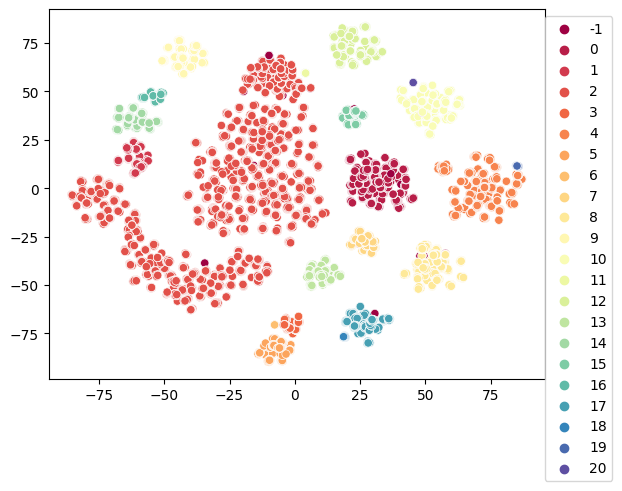

In [345]:
ax = sns.scatterplot(x=tsne_embeding_train[:,0], y=tsne_embeding_train[:,1], hue=db_labels_train, palette='Spectral', legend='full')
ax.legend(bbox_to_anchor=(1.15, 1), loc='upper right')
plt.show()

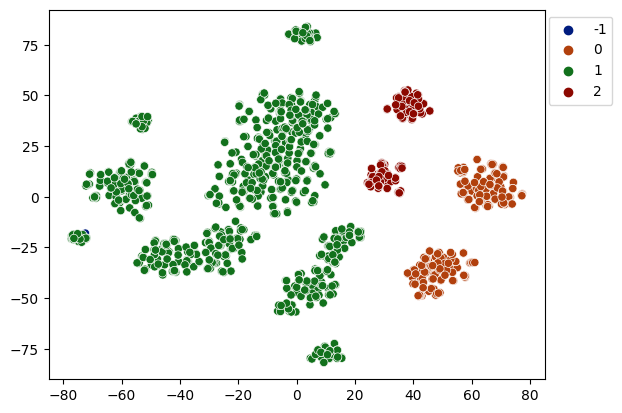

In [163]:
ax = sns.scatterplot(x=tsne_embeding_test[:,0], y=tsne_embeding_test[:,1], hue=db_labels_test, palette= 'dark', legend='full')
ax.legend(bbox_to_anchor=(1.15, 1), loc='upper right')
plt.show()

#### BIRCH
For birch model, the most important parameter is **'n_clusters'** which is the number of clusters and the best value is **2**. The silhouette score is immutable to the other parameters.

In [395]:
birch_model = build_model(n_clusters=14, threshold=20, branching_factor=150)[-2]
birch_model.fit(Xtrain)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('numeric',
                                                                   StandardScaler())]),
                                                  Index(['has_null', 'wave', 'age', 'age_o', 'samerace', 'importance_same_race',
       'importance_same_religion', 'pref_o_attractive', 'pref_o_sincere',
       'pref_o_intelligence', 'pref_o_funny', 'pref_o_ambitious',
       'attractive_o', 'sinsere_o', 'intelligenc...
       'interests_correlate', 'like', 'guess_prob_liked', 'met'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['gender', 'race', 'race_o'], dtype='object')),
                                                 ('count',
                                                  Pipeline(steps=[('count',
                                                                   CountEncoder(combine_min_nan_groups=True,
                                                                                handle_unknown='ignore'))]),
                                                  Index(['field'], dtype='object'))])),
                ('model', Birch(branching_factor=150, n_clusters=14))])

In [396]:
bc_labels_train = birch_model.fit_predict(Xtrain)

bc_silhouette_score_train = silhouette_score(Xtrain_encoded, bc_labels_train)
print(bc_silhouette_score_train)

0.4867423848034166


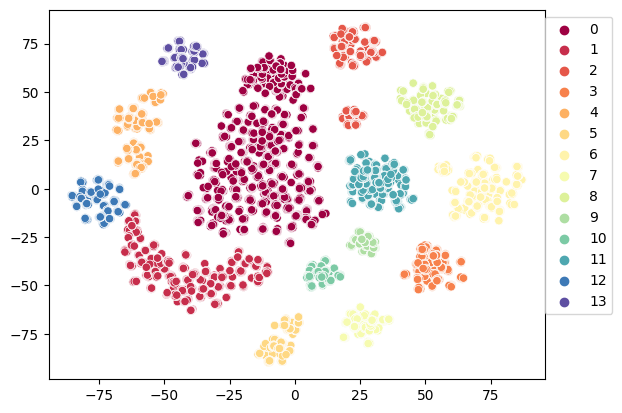

In [397]:
ax = sns.scatterplot(x=tsne_embeding_train[:,0], y=tsne_embeding_train[:,1], hue=bc_labels_train, palette= 'Spectral', legend='full')
ax.legend(bbox_to_anchor=(1.15, 1), loc='upper right')
plt.show()

In [106]:
# bc_labels_val = birch_model.fit_predict(Xval)

# bc_silhouette_score_val = silhouette_score(Xval_encoded, bc_labels_val.reshape(-1,))
# print(bc_silhouette_score_val)

In [166]:
bc_labels_test = birch_model.fit_predict(Xtest)

bc_silhouette_score_test = silhouette_score(Xtest_encoded, bc_labels_test)
print(bc_silhouette_score_test)

0.24950020294903535


In [19]:
bc_precision = precision_score(ytest, bc_labels_test, average='weighted')
bc_accuracy = accuracy_score(ytest, bc_labels_test)
bc_f1 = f1_score(ytest, bc_labels_test)

print(f'Precision score of birch model is: {bc_precision}')
print(f'Accuracy score of birch model is: {bc_accuracy}')
print(f'F1 score of birch model is: {bc_f1}')

Precision score of birch model is: 0.6969367060158181
Accuracy score of birch model is: 0.3347255369928401
F1 score of birch model is: 0.26499670402109426


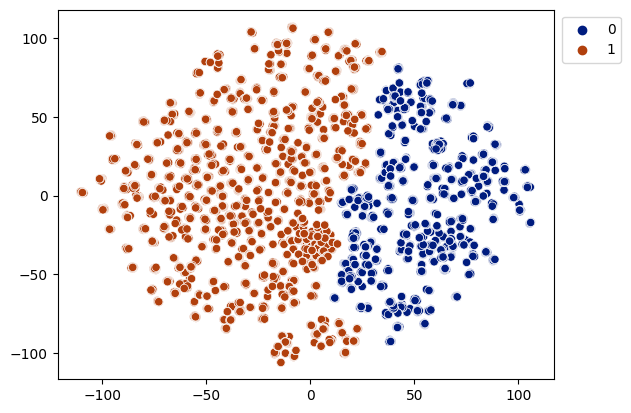

In [230]:
ax = sns.scatterplot(x=tsne_embeding_train[:,0], y=tsne_embeding_train[:,1], hue=bc_labels_train, palette= 'dark', legend='full')
ax.legend(bbox_to_anchor=(1.15, 1), loc='upper right')
plt.show()

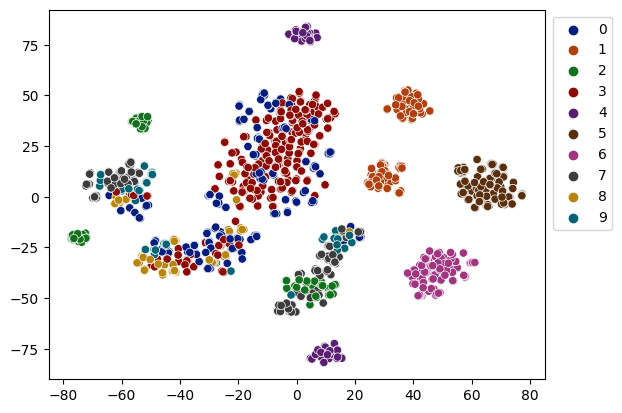

In [168]:
ax = sns.scatterplot(x=tsne_embeding_test[:,0], y=tsne_embeding_test[:,1], hue=bc_labels_test, palette= 'dark', legend='full')
ax.legend(bbox_to_anchor=(1.15, 1), loc='upper right')
plt.show()

#### KMEANS


In [358]:
models = build_model(n_clusters=12, init='random', n_init=20, max_iter=900, tol=1e-4, verbose=4, random_state=None, algorithm_k='lloyd')
km_model = models[1]
km_model.fit(Xtrain)

Initialization complete
Iteration 0, inertia 1456855.594908392.
Iteration 1, inertia 838188.4832170182.
Iteration 2, inertia 820420.2403582057.
Iteration 3, inertia 819249.7631640378.
Iteration 4, inertia 818935.1023297361.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 1181931.3985532084.
Iteration 1, inertia 750018.7671280627.
Iteration 2, inertia 739230.6796922415.
Iteration 3, inertia 738748.605990276.
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 1479642.060934443.
Iteration 1, inertia 755746.3923834322.
Iteration 2, inertia 675133.2153351231.
Iteration 3, inertia 674848.3322871157.
Iteration 4, inertia 674638.7534649924.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 1259671.150096564.
Iteration 1, inertia 729802.4725586239.
Iteration 2, inertia 722710.0480413276.
Iteration 3, inertia 711823.7155952232.
Iteration 4, inertia 702827.6884109761.
Iterat

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('numeric',
                                                                   StandardScaler())]),
                                                  Index(['has_null', 'wave', 'age', 'age_o', 'samerace', 'importance_same_race',
       'importance_same_religion', 'pref_o_attractive', 'pref_o_sincere',
       'pref_o_intelligence', 'pref_o_funny', 'pref_o_ambitious',
       'attractive_o', 'sinsere_o', 'intelligenc...
       'interests_correlate', 'like', 'guess_prob_liked', 'met'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['gender', 'race', 'race_o'], dtype='object')),
                                                 ('count',
                                                  Pipeline(steps=[('count',
                                                                   CountEncoder(combine_min_nan_groups=True,
                                                                                handle_unknown='ignore'))]),
                                                  Index(['field'], dtype='object'))])),
                ('model',
                 KMeans(max_iter=900, n_clusters=12, n_init=20, verbose=4))])

In [359]:
km_labels_train = km_model.fit_predict(Xtrain)

km_silhouette_score_train = silhouette_score(Xtrain_encoded, km_labels_train)
print(km_silhouette_score_train)

Initialization complete
Iteration 0, inertia 1288022.5614494246.
Iteration 1, inertia 699114.3301848233.
Iteration 2, inertia 698666.0164738996.
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 1249546.5433269376.
Iteration 1, inertia 695998.5499524365.
Iteration 2, inertia 689844.8893859921.
Iteration 3, inertia 688816.2196252027.
Iteration 4, inertia 688654.5636254278.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 1108028.0953362156.
Iteration 1, inertia 716411.2128118472.
Iteration 2, inertia 712067.7730694232.
Iteration 3, inertia 702827.688410976.
Iteration 4, inertia 692153.1323960838.
Iteration 5, inertia 676790.4663763884.
Iteration 6, inertia 670997.9589388727.
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 1117791.5672060945.
Iteration 1, inertia 688744.0048666422.
Converged at iteration 1: center shift 0.07667158072714089 within tolerance 0.08283

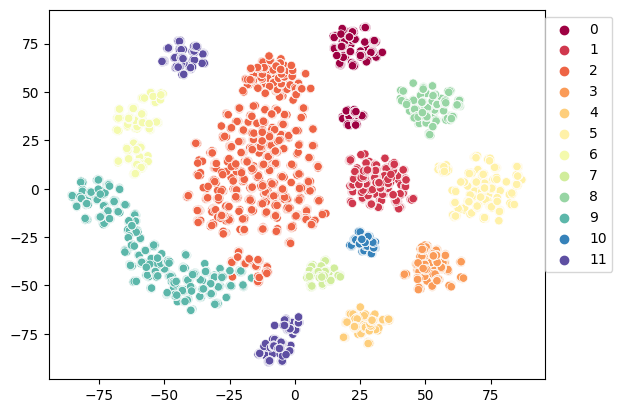

In [360]:
ax = sns.scatterplot(x=tsne_embeding_train[:,0], y=tsne_embeding_train[:,1], hue=km_labels_train, palette= 'Spectral', legend='full')
ax.legend(bbox_to_anchor=(1.15, 1), loc='upper right')
plt.show()

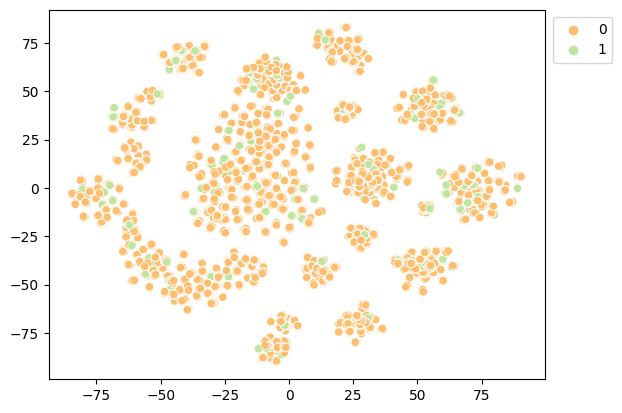

In [304]:
ax = sns.scatterplot(x=tsne_embeding_train[:,0], y=tsne_embeding_train[:,1], hue=ytrain.values.reshape((-1,)), palette= 'Spectral', legend='full')
ax.legend(bbox_to_anchor=(1.15, 1), loc='upper right')
plt.show()

In [203]:
# km_labels_val = km_model.fit_predict(Xval)

# km_silhouette_score_val = silhouette_score(Xval_encoded, km_labels_val.reshape(-1,))
# print(km_silhouette_score_val)

In [204]:
# km_labels_test = km_model.fit_predict(Xtest)

# km_silhouette_score_test = silhouette_score(Xtest_encoded, km_labels_test)
# print(km_silhouette_score_test)

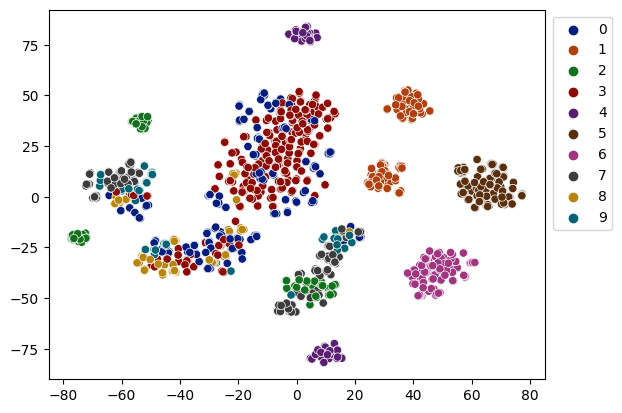

In [158]:
ax = sns.scatterplot(x=tsne_embeding_test[:,0], y=tsne_embeding_test[:,1], hue=bc_labels_test, palette= 'dark', legend='full')
ax.legend(bbox_to_anchor=(1.15, 1), loc='upper right')
plt.show()

#### OPTICS

- Valid values for metric are:

    - from scikit-learn: [‘cityblock’, ‘cosine’, ‘euclidean’, ‘l1’, ‘l2’, ‘manhattan’]

    - from scipy.spatial.distance: [‘braycurtis’, ‘canberra’, ‘chebyshev’, ‘correlation’, ‘dice’, ‘hamming’, ‘jaccard’, ‘kulsinski’, ‘mahalanobis’, ‘minkowski’, ‘rogerstanimoto’, ‘russellrao’, ‘seuclidean’, ‘sokalmichener’, ‘sokalsneath’, ‘sqeuclidean’, ‘yule’]

    Sparse matrices are only supported by scikit-learn metrics. See the documentation for scipy.spatial.distance for details on these metrics.

- Algorithm used to compute the nearest neighbors:

    - ‘ball_tree’ will use BallTree.

    - ‘kd_tree’ will use KDTree.

    - ‘brute’ will use a brute-force search.

    - ‘auto’ (default) will attempt to decide the most appropriate algorithm based on the values passed to fit method.

In [169]:
# TODO: before changing the metric parameter, try different min_samples
models = build_model(min_samples=50, metric='euclidean', p=2, cluster_method='xi', min_cluster_size=2, algorithm='auto', leaf_size=30)
op_model = models[2]
op_model.fit(Xtrain)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('numeric',
                                                                   StandardScaler())]),
                                                  Index(['wave', 'age', 'age_o', 'd_age', 'samerace', 'importance_same_race',
       'importance_same_religion', 'pref_o_attractive', 'pref_o_sincere',
       'pref_o_intelligence', 'pref_o_funny', 'pref_o_ambitious',
       'pref_o_shared_interests', 'attractive_o', '...
       'd_yoga', 'd_interests_correlate', 'd_expected_happy_with_sd_people',
       'd_expected_num_interested_in_me', 'd_expected_num_matches', 'd_like',
       'd_guess_prob_liked'],
      dtype='object')),
                                                 ('count',
                                                  Pipeline(steps=[('count',
                                                                   CountEncoder(combine_min_nan_groups=True,
                                                                                handle_unknown='ignore'))]),
                                                  Index(['field'], dtype='object'))])),
                ('model',
                 OPTICS(metric='euclidean', min_cluster_size=2,
                        min_samples=50))])

In [176]:
op_labels_train = op_model.fit_predict(Xtrain)
op_labels_test = op_model.fit_predict(Xtest)
# op_silhouette_score_train = silhouette_score(Xtrain_encoded, op_labels_train)
# op_silhouette_score_test = silhouette_score(Xtest_encoded, op_labels_test)
# print(op_silhouette_score_train)
# print(op_silhouette_score_test)

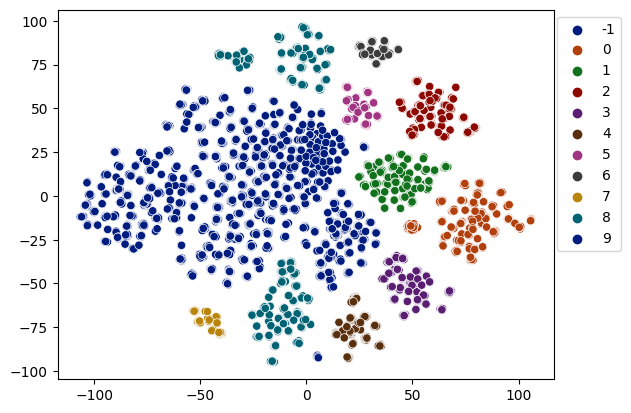

In [177]:
ax = sns.scatterplot(x=tsne_embeding_train[:,0], y=tsne_embeding_train[:,1], hue=op_labels_train, palette= 'dark', legend='full')
ax.legend(bbox_to_anchor=(1.15, 1), loc='upper right')
plt.show()

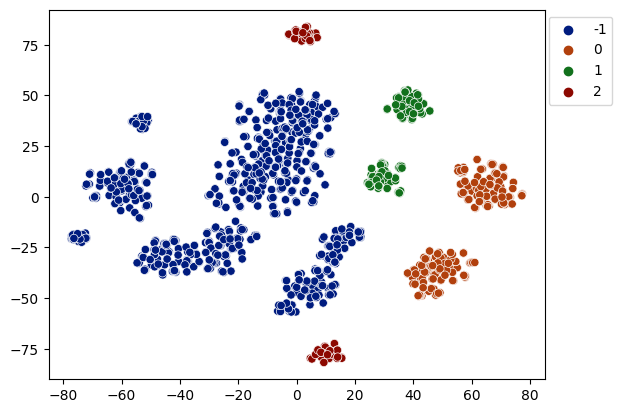

In [178]:
ax = sns.scatterplot(x=tsne_embeding_test[:,0], y=tsne_embeding_test[:,1], hue=op_labels_test, palette= 'dark', legend='full')
ax.legend(bbox_to_anchor=(1.15, 1), loc='upper right')
plt.show()

The 'affinity' parameter of AgglomerativeClustering must be a str among {'sokalmichener', 'rogerstanimoto', 'cosine', 'braycurtis', 'sokalsneath', 'dice', 'nan_euclidean', 'precomputed', 'l2', 'matching', 'canberra', 'l1', 'yule', 'cityblock', 'kulsinski', 'correlation', 'jaccard', 'sqeuclidean', 'euclidean', 'haversine', 'seuclidean', 'hamming', 'wminkowski', 'russellrao', 'manhattan', 'mahalanobis', 'minkowski', 'chebyshev'} or a callable

In [179]:
from sklearn.cluster import AgglomerativeClustering

# sokalmichener: silhouette score: 0.298, same as rogerstanimoto, matching, kulsinski, hamming. 
# canberra: silhouette score: 0.2437. yule: 0.105. 
# correlation: silhouette score: -0.8097. 
# jaccard: silhouette score: 0.25. 
# seuclidean: silhouette score: 0.394.

agg = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', AgglomerativeClustering(n_clusters=12, linkage='average', metric='seuclidean'))
])

In [180]:
agg.fit(Xtrain)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('numeric',
                                                                   StandardScaler())]),
                                                  Index(['wave', 'age', 'age_o', 'd_age', 'samerace', 'importance_same_race',
       'importance_same_religion', 'pref_o_attractive', 'pref_o_sincere',
       'pref_o_intelligence', 'pref_o_funny', 'pref_o_ambitious',
       'pref_o_shared_interests', 'attractive_o', '...
       'd_yoga', 'd_interests_correlate', 'd_expected_happy_with_sd_people',
       'd_expected_num_interested_in_me', 'd_expected_num_matches', 'd_like',
       'd_guess_prob_liked'],
      dtype='object')),
                                                 ('count',
                                                  Pipeline(steps=[('count',
                                                                   CountEncoder(combine_min_nan_groups=True,
                                                                                handle_unknown='ignore'))]),
                                                  Index(['field'], dtype='object'))])),
                ('model',
                 AgglomerativeClustering(linkage='average', metric='seuclidean',
                                         n_clusters=12))])

In [181]:
agg_labels_train = agg.fit_predict(Xtrain)
agg_labels_test = agg.fit_predict(Xtest)
# agg_silhou_train = silhouette_score(Xtrain_encoded, agg_labels_train.reshape(-1, ))
# agg_silhou_test = silhouette_score(Xtest_encoded, agg_labels_test.reshape(-1, ))
# print('Silhouette score of agglomerative cluster model on train dataset: ', agg_silhou_train)
# print('Silhouette score of agglomerative cluster model on test dataset: ', agg_silhou_test)

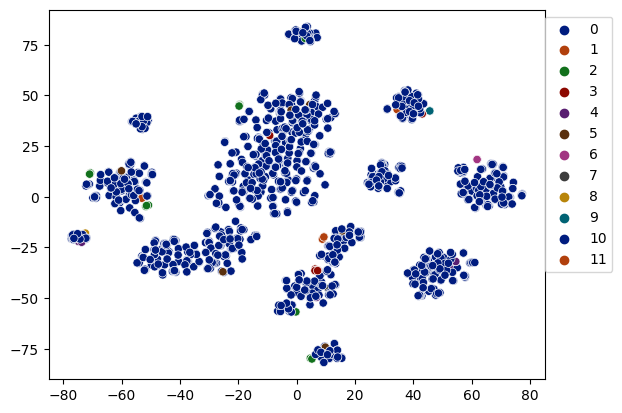

In [182]:
ax = sns.scatterplot(x=tsne_embeding_test[:,0], y=tsne_embeding_test[:,1], hue=agg_labels_test, palette= 'dark', legend='full')
ax.legend(bbox_to_anchor=(1.15, 1), loc='upper right')
plt.show()

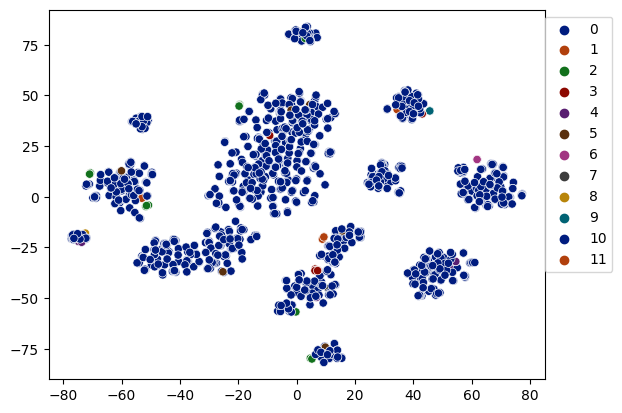

In [186]:
ax = sns.scatterplot(x=tsne_embeding_test[:,0], y=tsne_embeding_test[:,1], hue=agg_labels_test, palette= 'dark', legend='full')
ax.legend(bbox_to_anchor=(1.15, 1), loc='upper right')
plt.show()

In [193]:
from sklearn.cluster import BisectingKMeans

bikm = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', BisectingKMeans(n_clusters=8, init='k-means++', n_init=20))
])
bikm.fit(Xtrain)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('numeric',
                                                                   StandardScaler())]),
                                                  Index(['wave', 'age', 'age_o', 'd_age', 'samerace', 'importance_same_race',
       'importance_same_religion', 'pref_o_attractive', 'pref_o_sincere',
       'pref_o_intelligence', 'pref_o_funny', 'pref_o_ambitious',
       'pref_o_shared_interests', 'attractive_o', '...
       'd_yoga', 'd_interests_correlate', 'd_expected_happy_with_sd_people',
       'd_expected_num_interested_in_me', 'd_expected_num_matches', 'd_like',
       'd_guess_prob_liked'],
      dtype='object')),
                                                 ('count',
                                                  Pipeline(steps=[('count',
                                                                   CountEncoder(combine_min_nan_groups=True,
                                                                                handle_unknown='ignore'))]),
                                                  Index(['field'], dtype='object'))])),
                ('model', BisectingKMeans(init='k-means++', n_init=20))])

In [194]:
bikm_labels_train = bikm.fit_predict(Xtrain)
bikm_labels_test = bikm.fit_predict(Xtest)

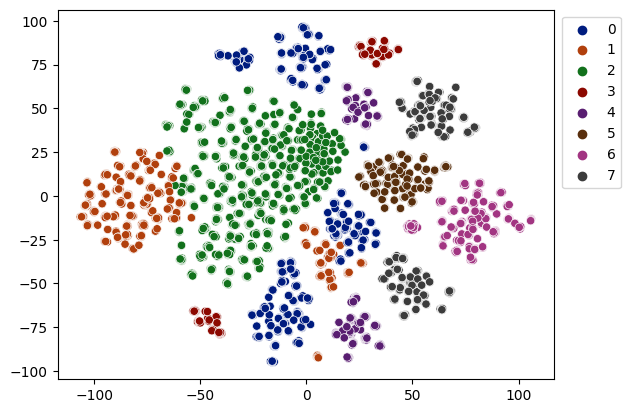

In [195]:
ax = sns.scatterplot(x=tsne_embeding_train[:,0], y=tsne_embeding_train[:,1], hue=bikm_labels_train, palette= 'dark', legend='full')
ax.legend(bbox_to_anchor=(1.15, 1), loc='upper right')
plt.show()

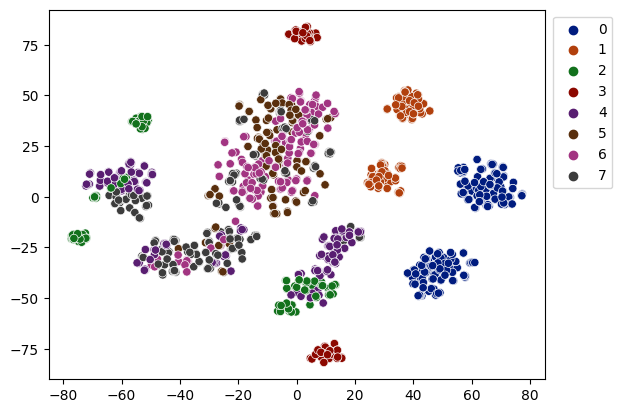

In [196]:
ax = sns.scatterplot(x=tsne_embeding_test[:,0], y=tsne_embeding_test[:,1], hue=bikm_labels_test, palette= 'dark', legend='full')
ax.legend(bbox_to_anchor=(1.15, 1), loc='upper right')
plt.show()

### Back to Feature selection
By adjusting parameters of model, we found that the evaluation metrics are still small. While when we checked the dataset, we found that the number of features is doubled. Therefore, we have a sparse dataset. To resolve this problem. we can use feature selection method to choose the features that are of higher importance. 

(5864, 240) (5864, 120)
